# Taller de introducción a Data Science
## Clasificación de canciones de Spotify

**Antes de empezar:**
- [Instalar spaCy y el modelo de lenguaje con el que van a trabajar](https://spacy.io/models#quickstart)

In [2]:
!pip install sentiment_analysis_spanish

     |████████████████████████████████| 15.1MB 299kB/s 


In [3]:
import os
import pandas as pd 
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics         import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import requests
import re
import numpy as np
from sentiment_analysis_spanish import sentiment_analysis
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

### 1) Recopilar los datos de las canciones

Para esta parte consideraremos [esta playlist colaborativa](https://open.spotify.com/playlist/2IuD0qZb14cji5y52crdsO?si=nfHRPDquQRyotEcXc4tG7Q), de esta obtendremos:
- Las features del audio de las canciones
- Las features textuales de sus letras

Además es necesario aplicar preprocesamiento y obtener el género de cada canción.

Luego, se separará al dataset resultante en **X** e **y**, donde:
- X es el conjunto de features
- y es la etiqueta, en este caso el género de la canción, que deberá ser codificado en valores del tipo **int**

Por último, se dividirá a estos dos conjuntos en los splits **train** y **test**

**Recomendaciones:**
- Obtener las features por separado y hacer un join de los datasets.
- Prestar atención a la [documentación de sklearn](https://scikit-learn.org/stable/)
- Si usan features categóricas, ENCODEARLAS!

### Análisis y exploración del dataset original

In [4]:
dataset_original = pd.read_csv('spotify_audio_features.csv', index_col=0)
dataset_original

,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,uri,duration_ms,time_signature,num_artists,track_name,genero,artist_name
danceability,,,,,,,,,,,,,,,,,,
0.161,0.482,1,-11.210,0,0.0472,0.4860,0.409000,0.371,0.0926,161.092,7j9DYPyCuvSAtPcevpAkzb,spotify:track:7j9DYPyCuvSAtPcevpAkzb,233079,5,1,Desafío,"['art pop', 'dance pop', 'deconstructed club',...",Arca
0.230,0.434,10,-12.402,0,0.0551,0.5700,0.000000,0.115,0.0834,80.793,1cwTMSQeMaA9fVKEF1iWeD,spotify:track:1cwTMSQeMaA9fVKEF1iWeD,216905,5,1,Anoche,"['art pop', 'dance pop', 'deconstructed club',...",Arca
0.289,0.280,9,-15.335,1,0.0433,0.8740,0.004430,0.124,0.0391,124.835,0aL27vskbMpwsMGUkHm3Zf,spotify:track:0aL27vskbMpwsMGUkHm3Zf,215773,3,1,Sin Rumbo,"['art pop', 'dance pop', 'deconstructed club',...",Arca
0.499,0.648,7,-5.812,1,0.0331,0.7230,0.000000,0.576,0.4640,88.140,2kfSFdq2h0xLXq01em1zc7,spotify:track:2kfSFdq2h0xLXq01em1zc7,219107,4,1,La Gata Bajo la Lluvia,"['bolero', 'cancion melodica', 'grupera', 'lat...",Rocío Dúrcal
0.528,0.383,2,-11.170,1,0.0258,0.3760,0.000000,0.110,0.4600,89.089,5ySxlyvySBhIEvoO2xx7uT,spotify:track:5ySxlyvySBhIEvoO2xx7uT,328320,4,1,Querida,"['cancion melodica', 'latin', 'latin pop']",Juan Gabriel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.714,0.753,7,-9.023,1,0.0309,0.0144,0.000003,0.325,0.9100,139.089,3TkZFF0JOcc8QXQyxqLB5J,spotify:track:3TkZFF0JOcc8QXQyxqLB5J,202333,4,1,El Divorcio,"['argentine rock', 'cuarteto', 'cumbia pop', '...",Rodrigo
0.408,0.828,7,-6.222,1,0.0622,0.7400,0.000000,0.322,0.4680,156.506,76DYAASchu5szMWFDuG1iP,spotify:track:76DYAASchu5szMWFDuG1iP,330493,4,1,"Tema de ""cabecita""","['argentine rock', 'cuarteto', 'cumbia pop', '...",Rodrigo
0.684,0.802,5,-6.619,0,0.0391,0.2360,0.000012,0.438,0.8390,150.167,1o7e4Tadn4o6nPvycwIP0C,spotify:track:1o7e4Tadn4o6nPvycwIP0C,260533,4,1,En Libertad,"['argentine rock', 'cuarteto', 'cumbia pop', '...",Rodrigo


Como podemos ver en el dataset original, cada una de las canciones posee más de un género asociado. Para facilitar el manejo de los datos se optó por separar cada una de las canciones en los géneros a la que se la asocia, por lo cual se obtuvo un dataframe donde aquellas canciones que poseían más de un género estaban repetidas, una vez por cada género asociado.

In [5]:
dataset_separado = pd.read_csv('genre_separated_df.csv', index_col=0)
dataset_separado

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,uri,duration_ms,time_signature,num_artists,track_name,genero,artist_name
0,0.161,0.482,1,-11.210,0,0.0472,0.486,0.40900,0.371,0.0926,161.092,7j9DYPyCuvSAtPcevpAkzb,spotify:track:7j9DYPyCuvSAtPcevpAkzb,233079,5,1,Desafío,12,Arca
1,0.161,0.482,1,-11.210,0,0.0472,0.486,0.40900,0.371,0.0926,161.092,7j9DYPyCuvSAtPcevpAkzb,spotify:track:7j9DYPyCuvSAtPcevpAkzb,233079,5,1,Desafío,38,Arca
2,0.161,0.482,1,-11.210,0,0.0472,0.486,0.40900,0.371,0.0926,161.092,7j9DYPyCuvSAtPcevpAkzb,spotify:track:7j9DYPyCuvSAtPcevpAkzb,233079,5,1,Desafío,39,Arca
3,0.161,0.482,1,-11.210,0,0.0472,0.486,0.40900,0.371,0.0926,161.092,7j9DYPyCuvSAtPcevpAkzb,spotify:track:7j9DYPyCuvSAtPcevpAkzb,233079,5,1,Desafío,49,Arca
4,0.161,0.482,1,-11.210,0,0.0472,0.486,0.40900,0.371,0.0926,161.092,7j9DYPyCuvSAtPcevpAkzb,spotify:track:7j9DYPyCuvSAtPcevpAkzb,233079,5,1,Desafío,50,Arca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,0.600,0.897,7,-5.833,1,0.0470,0.157,0.00061,0.877,0.7560,96.312,6Lkh9lukUEPBTZ1gewNT0m,spotify:track:6Lkh9lukUEPBTZ1gewNT0m,259587,4,1,Todo Me Lleva a Ti,10,Rodrigo
4932,0.600,0.897,7,-5.833,1,0.0470,0.157,0.00061,0.877,0.7560,96.312,6Lkh9lukUEPBTZ1gewNT0m,spotify:track:6Lkh9lukUEPBTZ1gewNT0m,259587,4,1,Todo Me Lleva a Ti,29,Rodrigo
4933,0.600,0.897,7,-5.833,1,0.0470,0.157,0.00061,0.877,0.7560,96.312,6Lkh9lukUEPBTZ1gewNT0m,spotify:track:6Lkh9lukUEPBTZ1gewNT0m,259587,4,1,Todo Me Lleva a Ti,35,Rodrigo
4934,0.600,0.897,7,-5.833,1,0.0470,0.157,0.00061,0.877,0.7560,96.312,6Lkh9lukUEPBTZ1gewNT0m,spotify:track:6Lkh9lukUEPBTZ1gewNT0m,259587,4,1,Todo Me Lleva a Ti,37,Rodrigo


Sin embargo, luego de generar este dataframe, nos topamos con dos inconvenientes:

- El dataset estaba muy desbalanceado, ya que algunos géneros estaban mucho más presentes que otros en la playlist.


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


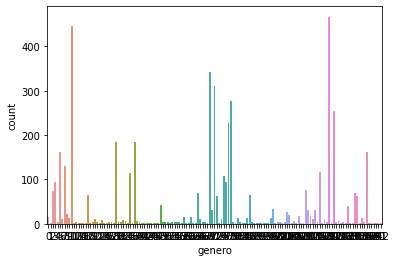

In [6]:
sns.countplot(dataset_separado.genero)

Incluso tomando los primeros 50 géneros podemos ver el desbalanceo

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


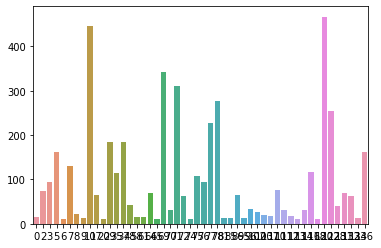

In [7]:
gen_keys = list(dataset_separado.genero.value_counts().keys())[:50]
gen_values = dataset_separado.genero.value_counts().values[:50]
sns.barplot(gen_keys, gen_values)

- Además nos percatamos que esto sería un problema al momento de entrenar los modelos ya que le estamos indicando que un mismo "x" puede tener más de un "y" asociado, lo cual no permitiría arrojar resultados precisos al momento de la clasificación.

Para lidiar con ambos inconvenientes decidimos proceder de la siguiente manera:

<ol>
<li>Aquellas canciones asociadas a más de un género, etiquetarlas con el género más popular de los que están asociados a dicha canción.</li>
<li>Finalmente quedarnos con los 5 géneros más populares de todo el dataset y limitar el alcance de los clasificadores a estos géneros, con la idea de que en un futuro si se desea abarcar mayor número de géneros, los clasificadores sean facilmente escalables.</li>
</ol>


### Selección de 5 géneros más populares

In [8]:
def turn_into_genre_list(song_genre):
    song_genre = song_genre.replace('[', '')
    song_genre = song_genre.replace(']', '')
    song_genre = song_genre.replace("'", '')
    song_genre = song_genre.split(',')
    return song_genre

In [9]:
dataset_original['genero'] = dataset_original.apply(lambda song : turn_into_genre_list(song.genero), axis=1)

In [10]:
genre_counter = Counter()
dataset_original.apply(lambda song : genre_counter.update(song.genero), axis=1)

danceability
0.161    None
0.230    None
0.289    None
0.499    None
0.528    None
         ... 
0.714    None
0.408    None
0.684    None
0.541    None
0.600    None
Length: 1188, dtype: object

In [11]:
# Estos son los 100 géneros más populares...
genre_counter.most_common(100)

[(' rock en espanol', 467),
 (' latin alternative', 303),
 ('argentine rock', 276),
 (' latin rock', 276),
 (' rock nacional', 254),
 ('latin', 232),
 (' latin pop', 227),
 (' argentine rock', 171),
 (' tropical', 162),
 ('cuarteto', 129),
 (' argentine metal', 123),
 (' cumbia villera', 119),
 (' reggaeton', 115),
 (' latin', 111),
 (' latin hip hop', 108),
 (' cumbia pop', 101),
 ('argentine heavy metal', 95),
 (' latin metal', 95),
 ('argentine indie', 86),
 (' puerto rican pop', 76),
 ('argentine alternative rock', 75),
 (' argentine indie', 75),
 (' spanish pop', 69),
 ('cumbia villera', 66),
 ('bolero', 65),
 (' mexican pop', 64),
 (' spanish pop rock', 62),
 (' latin arena pop', 62),
 (' indie cordoba', 59),
 (' cuarteto', 56),
 (' electronica argentina', 42),
 (' ska argentino', 40),
 (' nuevo folklore argentino', 33),
 (' latin afrobeat', 32),
 (' puerto rican rock', 32),
 (' rap conciencia', 32),
 (' pop argentino', 26),
 (' pop electronico', 20),
 (' post-punk argentina', 18

In [12]:
def get_most_common_genre(song_genres):
    max_count = 0
    max_name = ''
    for genre in song_genres:
        if max_count == 0:
            max_count = genre_counter[genre]
            max_name = genre
        elif genre_counter[genre] > max_count:
            max_count = genre_counter[genre]
            max_name = genre
    return max_name

In [13]:
dataset_original['most_common_genre'] = dataset_original.apply(lambda song : get_most_common_genre(song.genero), axis=1)

In [14]:
genre_counter_unique = Counter()
dataset_original.apply(lambda song : genre_counter_unique.update({song.most_common_genre: 1}), axis=1)
genre_counter_unique.most_common(1000)

[(' rock en espanol', 467),
 ('latin', 193),
 ('cuarteto', 129),
 (' latin pop', 68),
 ('cumbia villera', 66),
 ('argentine indie', 43),
 (' latin rock', 39),
 ('argentine alternative rock', 28),
 (' cumbia villera', 27),
 ('argentine rock', 18),
 ('', 16),
 ('grupera', 13),
 (' argentine rock', 11),
 ('indie cordoba', 10),
 (' spanish pop', 5),
 (' folklore argentino', 5),
 (' dance pop', 4),
 ('cumbia', 4),
 ('mexican indie', 4),
 ('bolero', 3),
 (' nueva cancion', 3),
 (' trap argentino', 3),
 (' argentine metal', 2),
 (' rock nacional', 2),
 ('latintronica', 2),
 ('flamenco', 2),
 (' tropical', 2),
 ('latin pop', 1),
 ('aggrotech', 1),
 ('chicha', 1),
 ('tango', 1),
 ('downtempo', 1),
 ('chamame', 1),
 ('argentine punk', 1),
 ('argentine metal', 1),
 ('charango', 1),
 ('bolivian rock', 1),
 ('folclore salteno', 1),
 ('folklore nuevo argentino', 1),
 (' reggaeton colombiano', 1),
 (' latin alternative', 1),
 (' pop rap', 1),
 (' reggaeton', 1),
 (' latin', 1),
 (' pop', 1),
 ('belgi

In [15]:
# Calculamos las proporciones de cada género
genre_proportions = []
for genre in genre_counter_unique:
    genre_proportion = genre, round(genre_counter_unique[genre] / sum(genre_counter_unique.values()) * 100.0, 4)
    genre_proportions.append(genre_proportion)

genre_proportions.sort(key=lambda genre_prop: genre_prop[1], reverse=True)
genre_proportions

[(' rock en espanol', 39.3098),
 ('latin', 16.2458),
 ('cuarteto', 10.8586),
 (' latin pop', 5.7239),
 ('cumbia villera', 5.5556),
 ('argentine indie', 3.6195),
 (' latin rock', 3.2828),
 ('argentine alternative rock', 2.3569),
 (' cumbia villera', 2.2727),
 ('argentine rock', 1.5152),
 ('', 1.3468),
 ('grupera', 1.0943),
 (' argentine rock', 0.9259),
 ('indie cordoba', 0.8418),
 (' spanish pop', 0.4209),
 (' folklore argentino', 0.4209),
 (' dance pop', 0.3367),
 ('cumbia', 0.3367),
 ('mexican indie', 0.3367),
 ('bolero', 0.2525),
 (' nueva cancion', 0.2525),
 (' trap argentino', 0.2525),
 (' argentine metal', 0.1684),
 (' rock nacional', 0.1684),
 ('latintronica', 0.1684),
 ('flamenco', 0.1684),
 (' tropical', 0.1684),
 ('latin pop', 0.0842),
 ('aggrotech', 0.0842),
 ('chicha', 0.0842),
 ('tango', 0.0842),
 ('downtempo', 0.0842),
 ('chamame', 0.0842),
 ('argentine punk', 0.0842),
 ('argentine metal', 0.0842),
 ('charango', 0.0842),
 ('bolivian rock', 0.0842),
 ('folclore salteno', 0.

A partir de estos resultados obtenidos, pudimos ver que el dataset estaba muy desbalanceado y debíamos tomar una decisión sobre a los géneros que tenían muy pocas canciones y decidir cómo proceder con aquellas canciones que poseían más de un género asociado.
Frente a esto decidimos por un lado, considerar para cada canción el género más popular dentro de nuestro dataset, enfocarnos solamente en los 5 géneros más populares del dataset y finalmente aumentar el dataset para balancear estos 5 géneros.

### Curación de datos

In [16]:
# Dataset de los 5 géneros más populares...
df = pd.read_csv('df_comm_genres.csv')
df = df.drop(columns=["Unnamed: 0", 'liveness', 'id', "uri", "num_artists", 'genero', 'track_name', 'artist_name'])

df.most_common_genre = df.most_common_genre.astype('str')
generos = df.most_common_genre.values



### Encoding del género (most common)


In [17]:
le = LabelEncoder()
generos_encoded = le.fit_transform(generos)

data_final = df.copy()
data_final['encoded_genres'] = generos_encoded

data_final.rename(columns={'most_common_genre':'genero'}, inplace=True)
data_final


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,duration_ms,time_signature,genero,encoded_genres
0,0.161,0.482,1,-11.210,0,0.0472,0.4860,0.409000,0.0926,161.092,233079,5,dance pop,17
1,0.230,0.434,10,-12.402,0,0.0551,0.5700,0.000000,0.0834,80.793,216905,5,dance pop,17
2,0.289,0.280,9,-15.335,1,0.0433,0.8740,0.004430,0.0391,124.835,215773,3,dance pop,17
3,0.499,0.648,7,-5.812,1,0.0331,0.7230,0.000000,0.4640,88.140,219107,4,latin,24
4,0.528,0.383,2,-11.170,1,0.0258,0.3760,0.000000,0.4600,89.089,328320,4,latin,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750,0.690,0.519,4,-7.241,1,0.0246,0.3140,0.000021,0.5230,90.978,230053,4,argentine indie,2
1751,0.616,0.395,2,-6.017,1,0.0301,0.2890,0.000006,0.3980,120.758,230867,3,argentine indie,2
1752,0.432,0.456,4,-7.259,1,0.0290,0.1320,0.000205,0.2310,98.843,208579,3,argentine indie,2
1753,0.557,0.656,7,-6.915,1,0.0295,0.0953,0.000043,0.2590,134.982,204675,4,argentine indie,2


### División de dataset en train y test

In [18]:
generos_de_interes = ['argentine rock', 'latin', 'cuarteto', 'cumbia villera', 'argentine indie']

df_interes = data_final.copy()
df_interes = df_interes[df_interes['genero'].isin(generos_de_interes)]
df_interes.reset_index(inplace=True)
df_interes.drop(columns='index', inplace=True)

columns = list(df_interes.columns)
columns.remove('genero')
columns.remove('encoded_genres')



X = df_interes[columns]
y = df_interes[['encoded_genres']]


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

## Sentiment Analysis

Para el análisis de sentimientos se procedió primero a extraer las letras de las canciones que forman parte del dataset y luego utilizar un modelo previamente entrenado de Sentiment Analysis para determinar un valor entre 0 y 1, según cuán "positivo" sea el sentimiento que expresa la frase de una canción.

In [ ]:
sentiment = sentiment_analysis.SentimentAnalysisSpanish()

def calculate_song_sentiment(artist_name, song_name):
    score_by_phrase = []
    
    lyrics_dict = requests.get('https://api.lyrics.ovh/v1/{:}/{:}'.format(artist_name, re.findall( "^[^\/]*",song_name)[0])).json()
    
    avg_score = -1
    min_score = -1
    max_score = -1
    
    if 'lyrics' in lyrics_dict:
        lyrics = lyrics_dict['lyrics']

        for sentence in lyrics.split('\n'):
            score_by_phrase.append(round(sentiment.sentiment(sentence), 4))

        avg_score = round(sum(score_by_phrase)/len(score_by_phrase), 4)
        min_score = round(max(score_by_phrase), 4)
        max_score = round(min(score_by_phrase), 4)
        
        return avg_score, min_score, max_score

Los valores devueltos por la función son:
   - Avg score: El promedio del sentiment score de toda una canción, calculado como la suma del score de todas sus frases sobre la cantidad de frases de la canción.
   - Min score: El mínimo sentiment score de una canción.
   - Max score: El máximo sentiment score de una canción. 

In [ ]:
# No ejecutaremos este bloque porque tarda mucho tiempo. En su lugar se levanta el dataset con las features de texto ya extraidas y agregadas...
min_lyrics_sentiment = list()
max_lyrics_sentiment = list()
avg_lyrics_sentiment = list()
df_sentiments = df_interes.copy()

for idx, song in df.iterrows():
    try:
        avg_score, min_score, max_score = calculate_song_sentiment(song.artist_name, song.track_name)
        print(str(idx) + '- Avg Score: ' + str(avg_score) + ' Min Score: ' + str(min_score) + ' Max Score: ' + str(max_score) + ' Artist: ' + song.artist_name + ' Song: ' + song.track_name)


        min_lyrics_sentiment.append(min_score)
        max_lyrics_sentiment.append(max_score)
        avg_lyrics_sentiment.append(avg_score)
    except:
        min_lyrics_sentiment.append(0)
        max_lyrics_sentiment.append(0)
        avg_lyrics_sentiment.append(0)

min_lyrics_sentiment = np.array(min_lyrics_sentiment).flatten()
max_lyrics_sentiment = np.array(max_lyrics_sentiment).flatten()
avg_lyrics_sentiment = np.array(avg_lyrics_sentiment).flatten()

df_sentiments['min_lyrics_sentiment'] = min_lyrics_sentiment
df_sentiments['max_lyrics_sentiment'] = max_lyrics_sentiment
df_sentiments['avg_lyrics_sentiment'] = avg_lyrics_sentiment

df_sentiments.to_csv('df_with_sentiment_bruto.csv')

0- Avg Score: 0.5047 Min Score: 0.5047 Max Score: 0.5047 Artist: Arca Song: Desafío
1- Avg Score: 0.5047 Min Score: 0.5047 Max Score: 0.5047 Artist: Arca Song: Anoche
2- Avg Score: 0.5047 Min Score: 0.5047 Max Score: 0.5047 Artist: Arca Song: Sin Rumbo
3- Avg Score: 0.5047 Min Score: 0.5047 Max Score: 0.5047 Artist: Rocío Dúrcal Song: La Gata Bajo la Lluvia
4- Avg Score: 0.4901 Min Score: 0.6505 Max Score: 0.339 Artist: Juan Gabriel Song: Querida
5- Avg Score: 0.4352 Min Score: 0.5208 Max Score: 0.0 Artist: Hermetica Song: Otro Día para Ser
6- Avg Score: 0.4828 Min Score: 0.6962 Max Score: 0.0002 Artist: Hermetica Song: Robo un Auto
7- Avg Score: 0.4652 Min Score: 0.8549 Max Score: 1e-04 Artist: Almafuerte Song: El Pibe Tigre
8- Avg Score: 0.5047 Min Score: 0.5047 Max Score: 0.5047 Artist: V8 Song: Deseando Destruir y Matar
9- Avg Score: 0.4662 Min Score: 0.7006 Max Score: 0.0005 Artist: Malon Song: Nido De Almas
10- Avg Score: 0.5047 Min Score: 0.5047 Max Score: 0.5047 Artist: Malon S

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

Luego de analizar los resultados arrojados por el análisis de sentimientos, pudimos darnos cuenta que un valor se repetía mucho entre todos:

In [ ]:
df_sentiments = pd.read_csv('df_with_sentiment_bruto.csv', index_col=0)
df_sentiments['max_lyrics_sentiment'].value_counts()

0.5047    1131
0.0000     194
0.0001      41
0.0002      24
0.0003      21
          ... 
0.0020       1
0.3316       1
0.0186       1
0.0445       1
0.0354       1
Name: max_lyrics_sentiment, Length: 214, dtype: int64

Luego de analizar las posibles causas, entendimos que la API que devuelve las letras de las canciones, no es efectiva y arroja resultados que el modelo de análisis de sentimientos no puede manejar. Debido a que esto pasa reiteradas veces con el total de canciones del dataset, el valor 0.5047 se repite demasiado. En base a esto y a la imposibilidad de corregirlo de manera correcta, se decidió excluir las features de texto del dataset de entrenamiento y evaluación ya que aportarán datos poco precisos y que generarán ruido en los modelos.

### 2) Elegir tres modelos de clasificadores multiclase

Aquí escogeremos tres modelos diferentes y luego compararemos su rendimiento para esta tarea. El procedimiento será el siguiente:
- Inicializar los modelos
- Entrenarlos usando el split **train** de los datos

**Recomendación:**
- Prestar atención a la [documentación de sklearn](https://scikit-learn.org/stable/)

## Clasificador Decision Tree

### Entrenamiento

In [19]:
if 'models' not in os.listdir('data/'):
    os.mkdir('data/models/')

In [20]:
dict_dec_tree_grid = {'criterion'         : ['gini', 'entropy'],
                      'splitter' : ['best', 'random'],
                      'max_depth': [5, 10, 30, 50, 100, 500, 1000],
                  'max_features'      : [None, 'auto'],
                  'min_samples_split' : [1, 5, 10, 25, 50, 75, 100, 150, 200, 300, 500],
                  'ccp_alpha'         : [0, 0.5, 1]
                  }



In [21]:
dt_model =      DecisionTreeClassifier(random_state=42)
clf =        GridSearchCV(dt_model, dict_dec_tree_grid, scoring='accuracy', cv=3, n_jobs=-1)
search =     clf.fit(X_train, y_train.values.flatten())
search_df =  pd.DataFrame(search.cv_results_)
best_d_tree =  search.best_estimator_
best_d_param = search.best_params_
print(best_d_tree)
print(best_d_param)

DecisionTreeClassifier(ccp_alpha=0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=25,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
{'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_split': 25, 'splitter': 'best'}


### Modelo basico sin optimizar

In [22]:
model_d_basic =      DecisionTreeClassifier(random_state=42)
model_d_basic.fit(X_train, y_train.values.flatten())
y_d_basic_pred =      model_d_basic.predict(X_valid)
acc_d_basic = accuracy_score(y_valid, y_d_basic_pred)
print(round(acc_d_basic, 5))


0.58043


### Modelo optimizado

In [23]:
d_model = best_d_tree
d_model.fit(X_train, y_train.values.flatten())
y_pred =      d_model.predict(X_valid)
d_acc = accuracy_score(y_valid, y_pred)
print(round(d_acc, 5))

if 'DecisionTree' not in os.listdir('data/models/'):
    os.mkdir('data/models/DecisionTree/')

with open('data/models/DecisionTree/model', 'wb') as dt_f:
    pickle.dump(d_model, dt_f)

0.55652


## Clasificador Random Forest

### Entrenamiento

In [24]:
dict_r_forest_grid = {'criterion'         : ['gini', 'entropy'],
                  'max_features'      : [None, 'auto'],
                  'min_samples_split' : [1, 5, 10, 25, 50, 75, 100, 150, 200, 300, 500],
                  'ccp_alpha'         : [0, 0.5, 1]
                  }


In [25]:
rf_model =      RandomForestClassifier(random_state=42)
clf =        GridSearchCV(rf_model, dict_r_forest_grid, scoring='accuracy', cv=3, n_jobs=-1)
search =     clf.fit(X_train, y_train.values.flatten())
search_df =  pd.DataFrame(search.cv_results_)
rf_best_tree =  search.best_estimator_
rf_best_param = search.best_params_
print(rf_best_tree)
print(rf_best_param)

RandomForestClassifier(bootstrap=True, ccp_alpha=0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
{'ccp_alpha': 0, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_split': 5}


### Modelo basico sin optimizar

In [26]:
rf_model_basic =      RandomForestClassifier(random_state=42)
rf_model_basic.fit(X_train, y_train.values.flatten())
y_basic_pred =      rf_model_basic.predict(X_valid)
rf_acc_basic = accuracy_score(y_valid, y_pred)
print(round(rf_acc_basic, 5))


0.55652


### Modelo optimizado

In [27]:
rf_model = rf_best_tree
rf_model.fit(X_train, y_train.values.flatten())
y_pred =      rf_model.predict(X_valid)
rf_acc = accuracy_score(y_valid, y_pred)
print(round(rf_acc, 5))

if 'RandomForest' not in os.listdir('data/models/'):
    os.mkdir('data/models/RandomForest/')

with open('data/models/RandomForest/model', 'wb') as rf_f:
    pickle.dump(rf_model, rf_f)

0.7


## Clasificadores Binarios con Random Forests

### Creación del dataset binario para cada género


In [28]:
path = 'data/'
generos_de_interes = ['argentine rock', 'latin', 'cuarteto', 'cumbia villera', 'argentine indie']

if not os.path.isdir(f'{path}'):
    os.mkdir(f'{path}')

for genero in generos_de_interes:
    if not os.path.isdir(f'{path}{genero}'):
        os.mkdir(f'{path}{genero}')
    
    df_pos = data_final[data_final['genero']==genero]
    df_pos.genero = 1
    count = df_pos.shape[0]
    df_neg = data_final[data_final['genero']!=genero].sample(count)
    df_neg.genero = 0
    
    df_final_genre = pd.concat([df_pos, df_neg])
    df_final_genre.drop(columns='encoded_genres', inplace=True)
    
    df_train, df_test = train_test_split(df_final_genre, test_size=0.3, random_state=42)
    df_train.to_csv(f'{path}{genero}/{genero}_train.csv')
    df_test.to_csv(f'{path}{genero}/{genero}_test.csv')                 

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Entrenamiento


In [29]:
dict_tree_grid = {'criterion'         : ['gini', 'entropy'],
                  'max_features'      : [None, 'auto'],
                  'min_samples_split' : [25, 50],
                  'ccp_alpha'         : [0],
                  'bootstrap'         : [True, False]
                  }


for genero in generos_de_interes:
    df_train = pd.read_csv(f'{path}{genero}/{genero}_train.csv', index_col=0)
    columns = df_train.columns.to_list()
    columns.remove('genero')
    
    X = df_train[columns]
    y = df_train['genero']
    print(f"Training {genero} model")
    
    model =      RandomForestClassifier(random_state=42)
    clf =        GridSearchCV(model, dict_tree_grid, scoring='accuracy', cv=3, n_jobs=-1)
    search =     clf.fit(X, y)
    best_tree =  search.best_estimator_

    with open(f'{path}{genero}/{genero}_model', 'wb') as f:
        pickle.dump(best_tree, f)

Training argentine rock model
Training latin model
Training cuarteto model
Training cumbia villera model
Training argentine indie model


### 3) Informe: Comparar el rendimiento de los modelos

Una vez entrenados los tres modelos, compararemos su rendimiento:
- Correr los modelos usando el split **test**
- Obtener el reporte de clasificación y la matriz de confusión para cada modelo
- Graficar llevando a 2 dimensiones nuestro split **test** pintando con colores diferentes según la etiqueta correspondiente.
- Graficar de manera similar los resultados obtenidos con cada clasificador y sobre esto la función de clasificación obtenida.
- Guardar los modelos usando **pickle**
- Discutir los resultados obtenidos

**Recomendación:**
- Prestar atención a la [documentación de sklearn](https://scikit-learn.org/stable/)

### Test y métricas

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools


In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize = (5,4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Etiqueta correcta')
    plt.xlabel('Etiqueta predicha')
    plt.show()

In [32]:
def show_scatter(X, y, model_title, model):
    pca = PCA(n_components=2, random_state=42)
    X_PC = pca.fit_transform(X)
    scaler = StandardScaler()
    X_PC = scaler.fit_transform(X_PC)
    #my_data = pd.DataFrame(scaler.fit_transform(X_PC), columns=['x', 'y'])
    my_data = pd.DataFrame(X_PC, columns=['x', 'y'])
    my_data['target'] = y
    model.fit(X_PC, y)
    plt.figure()
    ax = sns.scatterplot(my_data.x, my_data.y, hue=my_data.target, palette='Set2')
    #plt.scatter(my_data[(my_data.target == 1)].x, my_data[(my_data.target == 1)].y, color="dodgerblue", edgecolors='k', label="1")
    #plt.scatter(my_data[(my_data.target == 0)].x, my_data[(my_data.target == 0)].y, color="tomato", edgecolors='k', label="0")
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
    #xx, yy = np.meshgrid(np.linspace(*xlim, num=my_data.shape[0]), np.linspace(*ylim, num=my_data.shape[0]))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')
    plt.title(model_title)
    plt.grid()
    plt.legend()
    plt.show()
    

### Test clasificador Decision Tree


---------Testing Decision Tree model---------
              precision    recall  f1-score   support

           2       0.66      0.59      0.62        59
           6       0.68      0.53      0.59       194
          13       0.51      0.71      0.59        66
          16       0.54      0.51      0.52        72
          24       0.37      0.51      0.43        69

    accuracy                           0.56       460
   macro avg       0.55      0.57      0.55       460
weighted avg       0.58      0.56      0.56       460



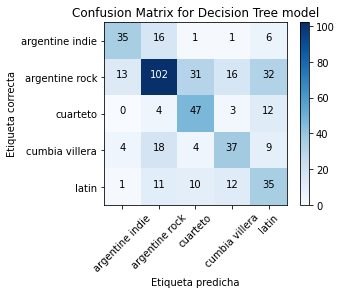

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


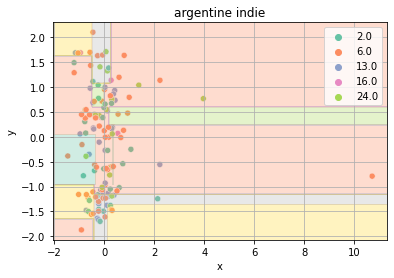

Decision Tree model accuracy: 0.5565217391304348


In [33]:
columns = X_train.columns.to_list()
dt_model = pickle.load(open('data/models/DecisionTree/model', 'rb'))
X = X_valid
y = y_valid

print(f"\n---------Testing Decision Tree model---------")
y_pred = dt_model.predict(X)
#Show classification report
print(classification_report(y, y_pred))
#Show Confusion matrix
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, ['argentine indie', 'argentine rock', 'cuarteto', 'cumbia villera', 'latin'], title="Confusion Matrix for Decision Tree model")
show_scatter(X, y, genero, dt_model)
#show_scatter(X, y_pred, genero+" estimado")
print(f'Decision Tree model accuracy: {str(accuracy_score(y, y_pred))}')


### Test clasificador Random Forest


---------Testing Random Forest model---------
              precision    recall  f1-score   support

           2       0.73      0.46      0.56        59
           6       0.70      0.86      0.77       194
          13       0.73      0.74      0.74        66
          16       0.68      0.65      0.67        72
          24       0.67      0.46      0.55        69

    accuracy                           0.70       460
   macro avg       0.70      0.64      0.66       460
weighted avg       0.70      0.70      0.69       460



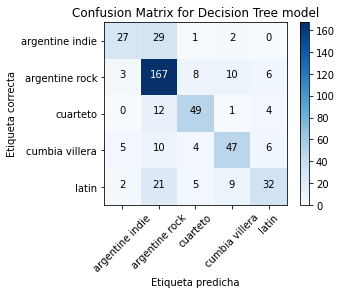

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


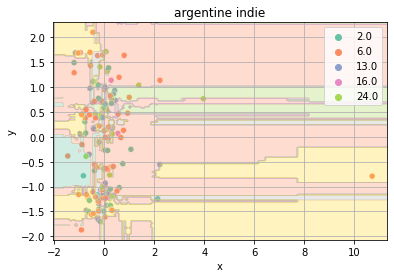

Decision Tree model accuracy: 0.7


In [34]:
columns = X_train.columns.to_list()
rf_model = pickle.load(open('data/models/RandomForest/model', 'rb'))
X = X_valid
y = y_valid

print(f"\n---------Testing Random Forest model---------")
y_pred = rf_model.predict(X)
#Show classification report
print(classification_report(y, y_pred))
#Show Confusion matrix
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, ['argentine indie', 'argentine rock', 'cuarteto', 'cumbia villera', 'latin'], title="Confusion Matrix for Decision Tree model")
show_scatter(X, y, genero, rf_model)
#show_scatter(X, y_pred, genero+" estimado")
print(f'Decision Tree model accuracy: {str(accuracy_score(y, y_pred))}')


### Test clasificadores binarios


---------Testing argentine rock model---------
              precision    recall  f1-score   support

           0       0.71      0.86      0.78       180
           1       0.85      0.70      0.77       207

    accuracy                           0.77       387
   macro avg       0.78      0.78      0.77       387
weighted avg       0.79      0.77      0.77       387



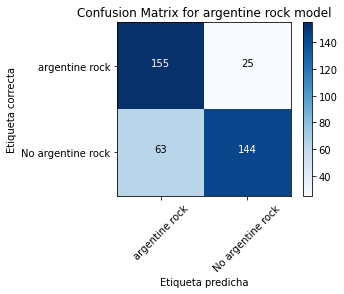

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


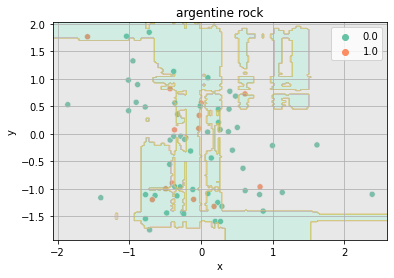

argentine rock model accuracy: 0.772609819121447

---------Testing latin model---------
              precision    recall  f1-score   support

           0       0.74      0.73      0.74        82
           1       0.72      0.73      0.72        77

    accuracy                           0.73       159
   macro avg       0.73      0.73      0.73       159
weighted avg       0.73      0.73      0.73       159



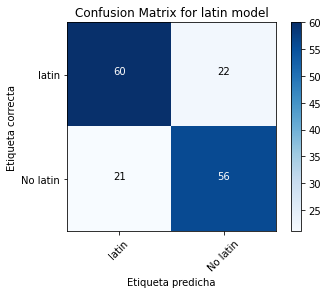

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


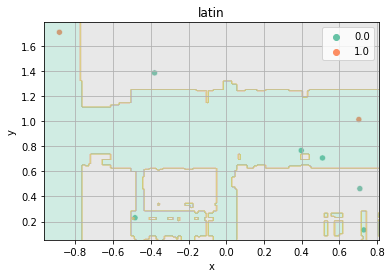

latin model accuracy: 0.7295597484276729

---------Testing cuarteto model---------
              precision    recall  f1-score   support

           0       0.85      0.84      0.85        69
           1       0.85      0.86      0.85        71

    accuracy                           0.85       140
   macro avg       0.85      0.85      0.85       140
weighted avg       0.85      0.85      0.85       140



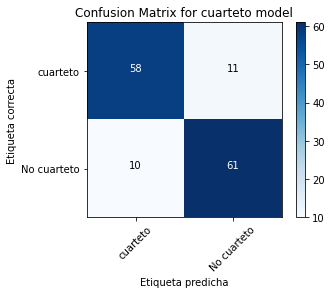

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


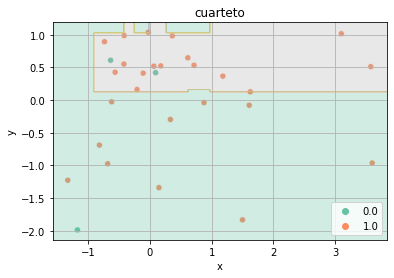

cuarteto model accuracy: 0.85

---------Testing cumbia villera model---------
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        64
           1       0.72      0.72      0.72        67

    accuracy                           0.71       131
   macro avg       0.71      0.71      0.71       131
weighted avg       0.71      0.71      0.71       131



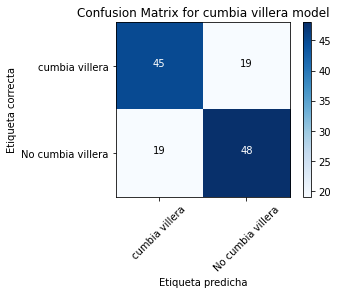

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


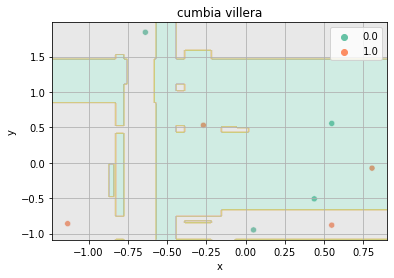

cumbia villera model accuracy: 0.7099236641221374

---------Testing argentine indie model---------
              precision    recall  f1-score   support

           0       0.70      0.92      0.79        50
           1       0.89      0.62      0.73        53

    accuracy                           0.77       103
   macro avg       0.79      0.77      0.76       103
weighted avg       0.80      0.77      0.76       103



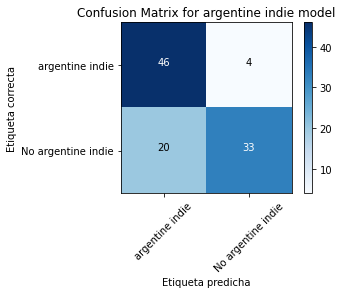

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


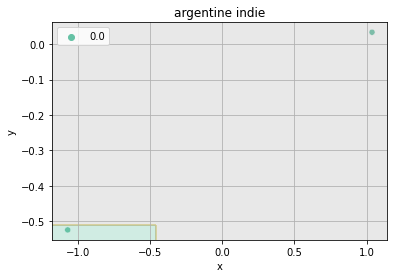

argentine indie model accuracy: 0.7669902912621359
Total accuracy: 0.7658167045866786


In [35]:
# Testing...  el accuracy se calcula como promedio del accuracy de cada clasificador individual
count = len(generos_de_interes)
acc = 0
acc_total = 0
files = ['argentine rock', 'latin', 'cuarteto', 'cumbia villera', 'argentine indie']

for genero in files:
    tran = le.transform([genero])[0]

    df_test = pd.read_csv(f'{path}{genero}/{genero}_test.csv', index_col=0)
    
    columns = df_train.columns.to_list()
    columns.remove('genero')
    
    model = pickle.load(open(f'{path}{genero}/{genero}_model', 'rb'))
    X = df_test[columns]
    y = df_test['genero']
    print(f"\n---------Testing {genero} model---------")
    y_pred = model.predict(X)
    
    #Show classification report
    print(classification_report(y, y_pred))
    
    #Show Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plot_confusion_matrix(cm, [f'{genero}', f'No {genero}'], title="Confusion Matrix for "+genero+" model")
    
    show_scatter(X, y, genero, model)
    #show_scatter(X, y_pred, genero+" estimado")
    acc += accuracy_score(y, y_pred)
    print(f'{genero} model accuracy: {str(accuracy_score(y, y_pred))}')
acc_total = acc/count
print(f'Total accuracy: {acc_total}')

### Análisis de resultados

En base a los resultados obtenidos, podemos observar que el mejor caso de los 3 presentados (Decision Tree, Random Forest y Clasificadores Binarios) fue el uso de Random Forests Classifiers como clasificadores binarios para cada uno de los géneros. Esto se debe a que la combinación de clasificadores binarios, a pesar de ser poco ventajosa en cuanto a recursos utilizados tanto en su entrenamiento como en la clasificación (en caso de modelos más complejos), son más precisos en casos de clasificaciones ONE vs ALL, ya que cada modelo se entrena con dos posibles salidas únicamente. Además, el uso de clasificadores binarios evita que el desbalanceo del dataset afecte en el rendimiento de la clasificación ya que cada modelo posee su conjunto de datos, independiente del resto, para su entrenamiento. Finalmente, esta arquitectura permite escalar facilmente en caso de que se deseen agregar nuevos géneros al clasificador y no afectar al resto de los modelos.

Tanto Random Forest como Decision Tree no son malas opciones tampoco (ambos arrojaron un accuracy mayores a 0.5) pero para obtener mejores resultados es necesario que la curación de los datos sea más minuciosa y el tunning de hiperparámetros más preciso.

Como conclusión, entendemos que la combinación de clasificadores binarios son una opción muy eficiente ya que contamos con una cantidad de datos reducidos y un número de clases de salida pequeño. Pero en caso de que se desee escalar a mayor cantidad de géneros, esta opción comenzará a ser cada vez más inviable debido a la cantidad de recursos que requiere el entrenamiento, testing y uso de los modelos en simultáneo.